# Network constrained DBSCAN clustering with Pandana

This notebook was inspired by a [blog post](https://geoffboeing.com/2018/04/network-based-spatial-clustering/#more-3125) and notebook [Cluster 1,000,000 points along a spatial network](https://github.com/gboeing/network-clustering/blob/master/network-clustering-node-based.ipynb) by Geoff Boeing which demonstrates network constrained clustering of 1,000,000 points with OSMnx, networkx and DBSCAN. In that example, although the use of a sparse matrix allowed a larger number of points to be handled on the network, there remain some constraints which prevent scaling to real world POIs in a larger city:

1. The 1,000,000 points are tightly clustered - once they are attached to the nodes in the network, there are only 549 nodes forming the basis of the origin-destination matrix. In another example even with just 35,000 POIs, if they are more evenly distributed, we may be trying to deal with 16,000 nodes. Just creating the OD matrix with that many entries can be a challenge.
2. The street network in the example is relatively small, even when trying to cluster a relatively low number of POIs/nodes calculating shortest distances can take a while with networkx.

This notebook combines OSMnx and DBSCAN with [Pandana](https://github.com/UDST/pandana) to suggest an alternative approach which may allow network constrained clustering of real-world POIs in a large city such as London.

## 0. Imports and settings

In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
import osmnx as ox
import seaborn as sns
import pandana
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from sklearn.cluster import DBSCAN
from pandana.loaders import osm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set options
pd.options.display.float_format = '{:.2f}'.format
ox.utils.config(use_cache=True, log_console=True)

print("Geopandas:", gpd.__version__)
print("Pandana:", pandana.__version__)
print("Pygeos:", gpd.options.use_pygeos)

Geopandas: 0.8.1
Pandana: 0.5.1
Pygeos: True


## 1a. Getting and saving network data with Pandana
***Only needs to be run once***

In [ ]:
network = osm.pdna_network_from_bbox(51.2426401231,-0.5633820667,51.7249656191,0.3072844372)  # London

# Saving
network.nodes_df.to_csv('nodes.csv')
network.edges_df.to_csv('edges.csv')

## 1b. Loading nodes and edges and recreating the network
***Run on subsequent occasions***

In [2]:
# Load nodes and edges
nodes = pd.read_csv('nodes.csv', index_col=0)
edges = pd.read_csv('edges.csv', index_col=[0,1])
# Combine to create network
network = pandana.Network(nodes['x'], nodes['y'], 
                          edges['from'], edges['to'], edges[['distance']])

## 2. Get POIs from OpenStreetMap with OSMnx

Pandana does have its own function for getting POIs from OSM but in this test OSMnx retrieved around 50% more POIs.

OSMnx will return points, linestrings and polygons so the coordinates are extracted from their centroids:

In [3]:
# get shop and office geometries from OSM
osmnx_pois = ox.geometries_from_place("London, UK", tags={"shop": True, "office": True})
# write their centoid lat, lon into columns
osmnx_pois['lon'] = osmnx_pois.geometry.centroid.x
osmnx_pois['lat'] = osmnx_pois.geometry.centroid.y

print(osmnx_pois.shape)
print(osmnx_pois.geom_type.unique())
osmnx_pois.head(2)

(35046, 694)
['Point' 'Polygon' 'LineString' 'MultiPolygon']


/home/nick/anaconda3/envs/atelierlibre/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.
/home/nick/anaconda3/envs/atelierlibre/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """


,unique_id,osmid,element_type,amenity,geometry,brand,name,operator,shop,wheelchair,...,name:af,name:gl,name:kn,name:th,name:zh2,alt_name:mi,listed_building,name:mi,lon,lat
0,node/21442271,21442271,node,fuel,POINT (-0.24344 51.39894),Esso,Esso,Esso,yes,yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.24,51.40
1,node/21663357,21663357,node,fuel,POINT (-0.34184 51.57911),NaN,bp,NaN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.34,51.58


Only the necessary columns are kept and we use Pandana to create a new column in the POIs dataframe which contains the id of the network node closest to each POI.

/home/nick/anaconda3/envs/atelierlibre/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of pois: 35046
Number of nearest nodes: 16703


,lat,lon,shop,office,name,geometry,nn
0,51.40,-0.24,yes,NaN,Esso,POINT (-0.24344 51.39894),1798018156
1,51.58,-0.34,yes,NaN,bp,POINT (-0.34184 51.57911),1313828779


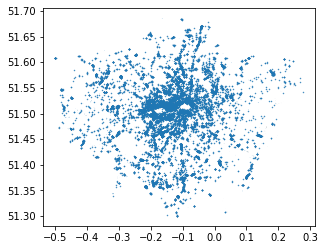

In [4]:
# Reduce the number of columns that we are dealing with
pois = osmnx_pois[['lat', 'lon', 'shop', 'office', 'name', 'geometry']].copy()

# Attache the id of the nearest network node to each shop
pois['nn'] = network.get_node_ids(pois.lon, pois.lat).values

print("Number of pois:", len(pois))
print("Number of nearest nodes:", len(pois['nn'].unique()))
pois.plot(markersize=0.2)
pois.head(2)

## 3. Setting parameters

Both Pandana and DBSCAN work with a threshold distance and they will only look for POIs or neighbours within that threshold distance. This means we can not only benefit from Pandana's contraction hierarchies but that also, unlike networkx, it doesn't have to consider the whole network when checking shortest paths. In this example we will use the epsilon value for DBSCAN as the `maxdist` value for Pandana as well.

***Note these parameters have not been fine tuned***

In [5]:
# DBSCAN parameters
eps = 300 # epsilon in metres (threshold distance for a node to be considered a neighbour)
min_pts = 7 # minimum number of neighbours (including self) required to be considered a core point

# Pandana parameters
maxitems = 80

/home/nick/anaconda3/envs/atelierlibre/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 4. Set the pois onto the Pandana network

- Also sets the maxdist and maxitems parameters to enable precomputation of shortcuts

In [6]:
network.set_pois(category = 'pois',
                 maxdist = eps,
                 maxitems = maxitems,
                 x_col = pois.lon, 
                 y_col = pois.lat)

/home/nick/anaconda3/envs/atelierlibre/lib/python3.7/site-packages/pandana/network.py:627: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/nick/anaconda3/envs/atelierlibre/lib/python3.7/site-packages/pandana/network.py:635: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


## 5. Find the nearest POIs to each node

This will return the distances from every node in the network (id) to the specified number of nearest POIs within the threshold distance. The idea behind this is that because many potential neighbours will be beyond the threshold distance of the DBSCAN epsilon, it is only necessary to calculate the shortest path between neighbours within epsilon.

***Note that when no further POIs are within reach Pandana returns the maximum distance value and nan for the POI id. These will be removed later in the process. Also note that Pandana has a second threshold on the maximimum number of POIs it will find within the distance, this may be problematic if the distance is set very high or the POIs are very close together.***

In [7]:
results = network.nearest_pois(distance = eps,
                               category = 'pois',
                               num_pois = maxitems,
                               include_poi_ids = True)
results.head()

/home/nick/anaconda3/envs/atelierlibre/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,1,2,3,4,5,6,7,8,9,10,...,poi71,poi72,poi73,poi74,poi75,poi76,poi77,poi78,poi79,poi80
id,,,,,,,,,,,,,,,,,,,,,
78112,281.12,281.12,281.12,281.12,281.12,281.12,300.00,300.00,300.00,300.00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
99880,228.90,280.79,287.80,300.00,300.00,300.00,300.00,300.00,300.00,300.00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
99884,155.23,207.12,214.12,269.65,300.00,300.00,300.00,300.00,300.00,300.00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
99901,261.68,300.00,300.00,300.00,300.00,300.00,300.00,300.00,300.00,300.00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
99907,222.77,229.96,243.65,243.65,291.74,291.74,291.74,300.00,300.00,300.00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


Here we can see that 4,052 of the 482,135 nodes have at least 80 POIs within reach.

In [8]:
print(len(results))
print(len(results['poi80'].unique()))

482135
4049


/home/nick/anaconda3/envs/atelierlibre/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The `results` dataframe has the node id as the index and the POI ids in the columns. We join the `results` dataframe onto the POIs dataframe to get distances from POI to POI.

In [9]:
# Here we use the nearest node to each shop to join the results to the shops
pois_results = pois[['nn']].join(results, on='nn', how='left')
pois_results.head()

,nn,1,2,3,4,5,6,7,8,9,...,poi71,poi72,poi73,poi74,poi75,poi76,poi77,poi78,poi79,poi80
0,1798018156,0.00,10.70,75.44,103.49,119.12,128.52,144.55,159.68,159.68,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,1313828779,0.00,21.90,132.59,161.30,162.77,162.77,218.67,224.03,300.00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,1678452778,0.00,10.40,35.41,35.41,35.41,38.66,42.99,50.28,50.28,...,32407.00,2158.00,2155.00,2180.00,2154.00,2840.00,8719.00,8715.00,10838.00,2153.00
3,3101789655,0.00,0.00,0.00,59.48,59.48,59.48,94.14,94.14,123.60,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,6801310569,0.00,109.63,278.55,278.55,293.49,300.00,300.00,300.00,300.00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


## 6. Convert the `pois_results` dataframe to a long format sparse matrix suitable for use with DBSCAN

In [10]:
# create a new empty dataframe
results_long = pd.DataFrame()

# stack the pairs of distances and poi ids
for n in range(1, maxitems+1):
    temp_df = pois_results[[n, f"poi{n}"]]
    temp_df = temp_df.rename(columns={n:'data', f"poi{n}":'col'}).copy()
    temp_df['row'] = temp_df.index

    results_long = results_long.append(temp_df, ignore_index=True)

# reset the index
results_long.reset_index(drop=True, inplace=True)

print(results_long.shape)
results_long.head(2)

/home/nick/anaconda3/envs/atelierlibre/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2803680, 3)


,data,col,row
0,0.00,0.00,0
1,0.00,1.00,1


Drop any `nan` values. This will also remove the distances that Pandana returned as the default maximum distance.

In [11]:
results_long = results_long.dropna()
print(results_long.shape)

(1597070, 3)


/home/nick/anaconda3/envs/atelierlibre/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
row = results_long['row'].values
col = results_long['col'].values
data = results_long['data'].values

dimension = len(pois)

/home/nick/anaconda3/envs/atelierlibre/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Create the sparse matrix

In [13]:
pois_dm = csr_matrix((data, (row, col)), shape=(dimension, dimension))

## 7. Cluster the pois based on this sparse matrix
Use the sparse network-based distance matrix to compute DBSCAN (converges much faster and uses much less memory than using the dense matrix with a big data set).

In [14]:
# create an instance of DBSCAN
# use metric=precomputed to fit model to the sparse network-based distance matrix
db = DBSCAN(eps=eps, min_samples=min_pts, metric='precomputed')

# Fit_predict based on the sparse matrix
cluster_labels = db.fit_predict(pois_dm)

/home/nick/anaconda3/envs/atelierlibre/lib/python3.7/site-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


Create a new column in the `pois` dataframe with the cluster labels in:

In [15]:
pois['cluster_labels'] = cluster_labels

/home/nick/anaconda3/envs/atelierlibre/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 8. Compare the largest clusters with town centre boundaries downloaded from data.london.gov.uk

In [16]:
town_centres = gpd.read_file("https://data.london.gov.uk/download/town_centre_boundaries/fbc02d8e-ab80-4db3-9c2b-8d4dd6ef6b68/Town_Centre_Boundaries.gpkg")
len(town_centres)

209

In [17]:
# Cluster ids with most POIs
top_pois = pois['cluster_labels'].value_counts().index[:210].to_list()

# Remove the id '-1' which is the id for POIs categorised as noise
top_pois.remove(-1)

Project the pois so that they plot over the town centres

In [18]:
pois.to_crs(epsg=27700, inplace=True)

### Show the results

/home/nick/anaconda3/envs/atelierlibre/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


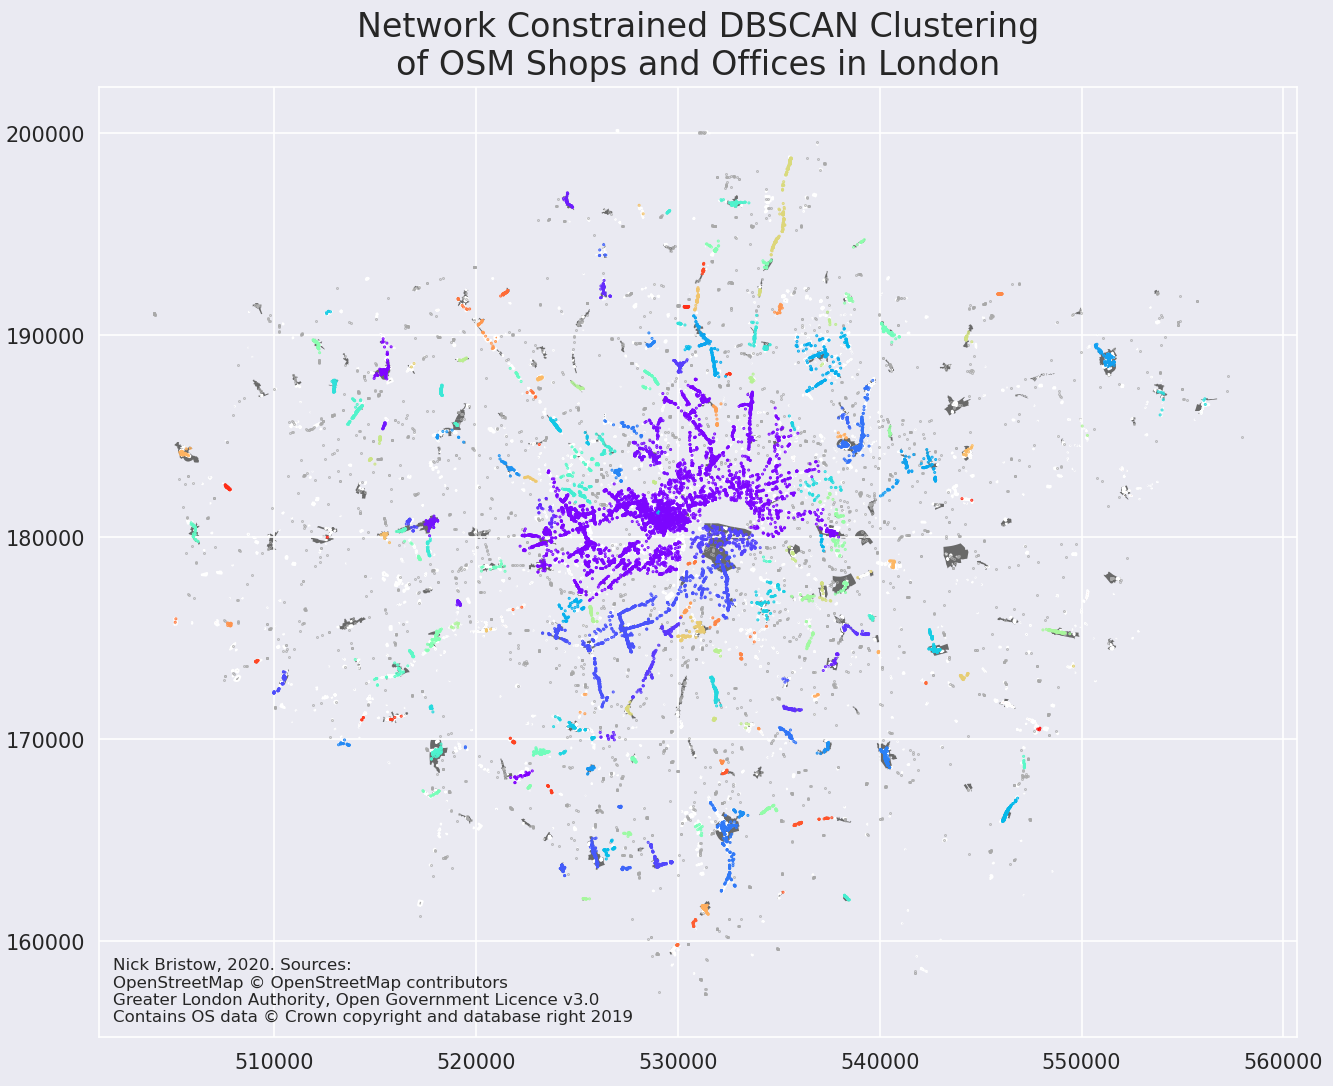

In [35]:
# Seaborn style
with sns.axes_style("darkgrid", {'figure.facecolor': '#EAEAF2'}):
    # Plot size and dpi
    fig, ax = plt.subplots(figsize=(9,8), dpi=150)
    # Greater London town centres
    town_centres.plot(ax=ax,
                      facecolor='dimgrey',
                      edgecolor='none',
                      zorder=0,
    )
    # Plot POIs not in the largest clusters as black dots
    pois[~pois['cluster_labels'].isin(top_pois)].plot(ax=ax,
                                                      color='darkgrey',
                                                      markersize=0.1,
                                                      zorder=1
    )
    # Plot the largest POI clusters with colours
    pois[pois['cluster_labels'].isin(top_pois)].plot(ax=ax,
                                                     column='cluster_labels',
                                                     cmap='rainbow',
                                                     categorical=True,
                                                     markersize=0.2,
                                                     zorder=2
    )
    # Title
    ax.set_title(label="Network Constrained DBSCAN Clustering\n"
                       "of OSM Shops and Offices in London",
                 fontdict={'fontsize':16,
                          })
    # Attribution
    ax.text(502000,
            156000,
            "Nick Bristow, 2020. Sources:\n"
            "OpenStreetMap © OpenStreetMap contributors\n"
            "Greater London Authority, Open Government Licence v3.0\n"
            "Contains OS data © Crown copyright and database right 2019",
            fontdict={'fontsize':8,
                     })
    # Save the file
    fig.tight_layout()
    fig.savefig('Network_constrained_clustering.png', facecolor='#EAEAF2')